# DPA Calculation 304SS
### Liam Hughes

<div class="alert alert-block alert-info"> This uses the Pysrim package to run SRIM calculations </div>



In [8]:
#pip install pysrim
#pip install --upgrade pyyaml==5.4.1 #to get the package working
import srim
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
import os

import numpy as np
import matplotlib.pyplot as plt

from srim import TRIM, Ion, Layer, Target
from srim.output import Results, EnergyToRecoils, Phonons
from srim.input import AutoTRIM, TRIMInput, SRInput


import os
from collections import Counter
from itertools import count
from random import randint
from pathlib import Path
import math
# Specify the directory of SRIM.exe
# For windows users the path will include C://...
#SRIM on desktop
srim_executable_directory = 'C:/Users/peppe/Desktop/SRIM'
print('SRIM Location =', srim_executable_directory)
output_directory = 'C:/Users/peppe/Desktop/SRIM_Output/SS304/2.9MeV'
print(output_directory)

#Some displacement energies for popular elements
from enum import Enum
class E_d(Enum):
    #Elements
    C = 69
    Si = 37
    Cr = 40
    Mn = 33
    Fe = 40
    Ni = 33
    Mo = 65
    W = 90
    Nb = 78
    V = 57
    #Some more...
    Al = 27
    Mg = 20
    P = 20
    S = 20
    Ti = 30
    Co = 36
    Cu = 30
    Y = 36
    Zr = 40
    N = 28 #not sure, using SRIM default

Python version
3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
SRIM Location = C:/Users/peppe/Desktop/SRIM
C:/Users/peppe/Desktop/SRIM_Output/SS304/2.9MeV


<div class="alert alert-block alert-danger"> If there is an error loading Pysrim, try and downgrade the version of Pyyaml. Using <b>pip install --upgrade pyyaml==5.4.1</b> to get the package working</div>

In [13]:
# G91 Steel SRIM Calculation
ion = Ion('H', energy=2.9e6)
width = 40 # um


# Construct a layer of G91 steel, 40um thick
SS304 = Layer({
        'Fe': {
            'stoich': 66.495,
            'E_d': E_d.Fe.value,
            'lattice': 0,
            'surface': 0
        }
        ,'C': {
            'stoich': 0.08,
            'E_d': E_d.C.value,
            'lattice': 0,
            'surface': 0
        },'Cr': {
            'stoich': 20.0,
            'E_d': E_d.Cr.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Mn': {
            'stoich': 2.0,
            'E_d': E_d.Mn.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Ni': {
            'stoich': 10.5,
            'E_d': E_d.Ni.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Si': {
            'stoich': 0.75,
            'E_d': E_d.Si.value,
            'lattice': 0,
            'surface': 0
        }
        ,'P': {
            'stoich': 0.045,
            'E_d': E_d.P.value,
            'lattice': 0,
            'surface': 0
        },'S': {
            'stoich': 0.03,
            'E_d': E_d.S.value,
            'lattice': 0,
            'surface': 0
        },'N': {
            'stoich': 0.1,
            'E_d': E_d.N.value,
            'lattice': 0,
            'surface': 0
        }
        }, density=8.00, width=width*10000, name='SS304')

trim_settings = {
    'calculation': 1, # 1 = Quick KP Calc ,2 = full cascade
    #'collisions': 2,
    # 'angle_ions': 30
} 

# Construct a target of a single layer
target = Target([SS304]) #can add more layers in array form



# Start TRIM Calculation

In [15]:
# Initialize a TRIM calculation with given target and ion for 99999 ions, quick calculation - see trim_settings
trim = TRIM(target, ion, number_ions=99999, **trim_settings)
results = trim.run(srim_executable_directory)
os.makedirs(output_directory, exist_ok=True)
TRIM.copy_output_files(srim_executable_directory, output_directory)

<div class="alert alert-block alert-info"> This code can automate SRIM calculations, by running with a range of energies </div>

In [32]:
#Loop through different energies
for i in range(1,11):
    trim = TRIM(target, Ion('H', energy=i*1e6), number_ions=9999, **trim_settings)
    results = trim.run(srim_executable_directory)
    os.makedirs(output_directory+str(i)+'MeV', exist_ok=True)
    TRIM.copy_output_files(srim_executable_directory, output_directory+str(i)+'MeV')

#  Analysis of the SRIM calculation

In [16]:
folders = [output_directory] #output_directory ###
energies = ['2.9 MeV'] ###

# folders = []
# energies = []
# for i in range(1,37,1):
#     folders.append(output_directory+str(i)+'MeV')
#     energies.append(str(i)+' MeV')

image_directory = 'C:/Users/peppe/Desktop/SRIM_images'
os.makedirs(image_directory, exist_ok=True)

def plot_dpa(folder, ax, time):
    results = Results(folder)
    vac = results.vacancy
    vacancy_depth = vac.knock_ons + np.sum(vac.vacancies, axis=1) #sum all vacancies
    atom_density = 8.484E22 #G91 ###
    atoms = atom_density*1.0E-8 #get number of atoms (10^8 Ang/cm)/(atoms/cm^3)]*(ions/cm^2 * s)
    dpa = (vacancy_depth)/(atoms)
    fluence = 6.25E+18 # number of H ions 1/1.6e-19
    current = 7.50E-6  #15.0E-6 #7.50E-06
    flux = fluence*current
    #charge = 0.352
    #area = 0.7854
    #dpa = (charge*fluence*dpa)/(area)
    dpa = dpa * flux * time * 3600 #hours -> seconds
    return([vac.depth/10000, dpa])

def NRT(folder, ax, time):
    results = Results(folder)
    phon = results.phonons
    ioniz = results.ioniz
    e2recoil = results.etorecoils
    
    dx = phon.depth / 100.0 # to units of Angstroms
    energy_damage = (phon.ions + phon.recoils) #* dx
    depth = max(e2recoil.depth) / 100.0 # to units of Angstroms
    tdam = (e2recoil.ions - ioniz.recoils) #* depth
    #tdam = (-phon.ions + phon.recoils) * dx
    nrt = (0.8*tdam)/(2*E_d.Fe.value)

    atom_density = 8.484E22 #G91 ###
    atoms = atom_density*1.0E-8 #get number of atoms
    fluence = 6.25E+18 # number of H ions 1/1.6e-19
    current = 7.50E-6#15.0E-6 #7.50E-06
    flux = fluence*current
    
    x_ = phon.depth/10000
    dpa = (nrt*flux*time*3600) / atoms
    return [sum(energy_damage), x_, dpa]

def NRT2(folder, ax, time):
    results = Results(folder)
    phon = results.phonons
    ioniz = results.ioniz
    e2recoil = results.etorecoils
    
    dx = max(phon.depth) / 100.0 # to units of Angstroms
    tdam = (phon.recoils - phon.ions) 
    nrt = (0.8*tdam)/(2*E_d.Fe.value)

    atom_density = 8.484E22 #G91 ###
    atoms = atom_density*1.0E-8   #0.00000001 #get number of atoms
    fluence = 6.25E+18 # number of H ions 1/1.6e-19
    current = 7.50E-6#15.0E-6 #7.50E-06
    flux = fluence*current
    
    x_ = phon.depth/10000
    dpa = (nrt*flux*time*3600) / atoms
    return [nrt, x_, dpa]

NRT dpa: 0.06 at 33.2 µm, proton energy: 2.9 MeV, for 1 hours
NRT dpa: 0.18 at 33.2 µm, proton energy: 2.9 MeV, for 3 hours
NRT dpa: 0.3 at 33.2 µm, proton energy: 2.9 MeV, for 5 hours
NRT dpa: 0.41 at 33.2 µm, proton energy: 2.9 MeV, for 7 hours
NRT dpa: 0.53 at 33.2 µm, proton energy: 2.9 MeV, for 9 hours
NRT dpa: 0.65 at 33.2 µm, proton energy: 2.9 MeV, for 11 hours
NRT dpa: 0.77 at 33.2 µm, proton energy: 2.9 MeV, for 13 hours
NRT dpa: 0.89 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours
NRT dpa: 1.01 at 33.2 µm, proton energy: 2.9 MeV, for 17 hours
NRT dpa: 1.12 at 33.2 µm, proton energy: 2.9 MeV, for 19 hours


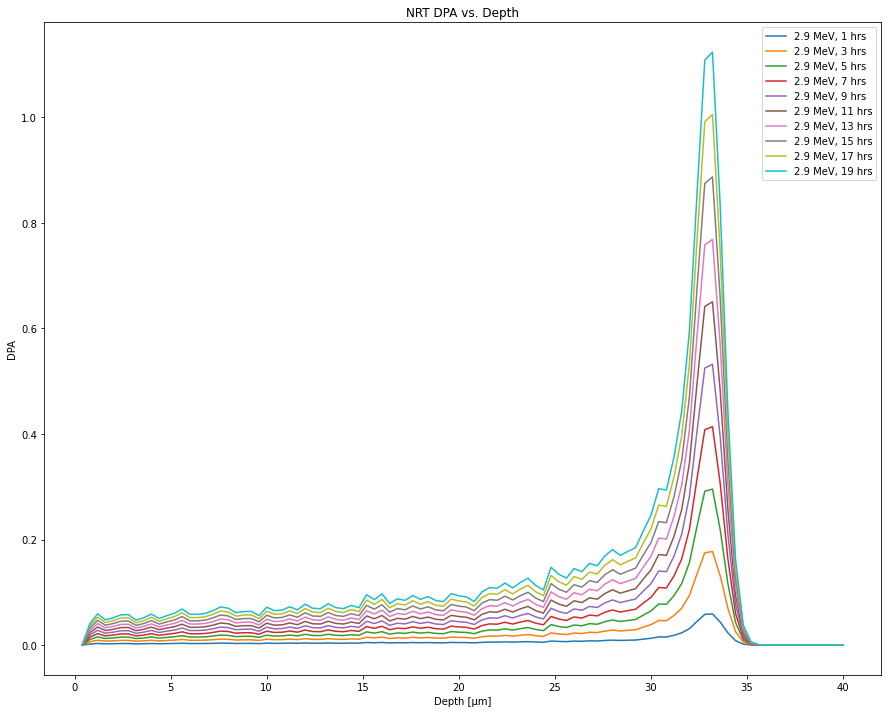

In [22]:
fig, ax = plt.subplots()

times = list(range(1, 20,2)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        energy_damage = NRT2(folder, ax, time)
        ax.plot(energy_damage[1], energy_damage[2], label=""+str(energies[i])+", "+str(time)+" hrs")
        #print("Damage energy: {} eV".format(energy_damage[0]))
        ax.set_xlabel('Depth [µm]')
        ax.set_ylabel('DPA')
        ax.legend()
        
        index = np.where(energy_damage[2] == max(energy_damage[2]))
        a = energy_damage[1][index]
        d = str(a)[1:-1]
 
        print("NRT dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(energy_damage[2]),2), d, energies[i], time))
        
    ax.set_title('NRT DPA vs. Depth')
    fig.set_size_inches((15, 12))
    fig.savefig(os.path.join(image_directory, 'damagevsdepth.png'), transparent=True)

Max dpa: 1.13 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours


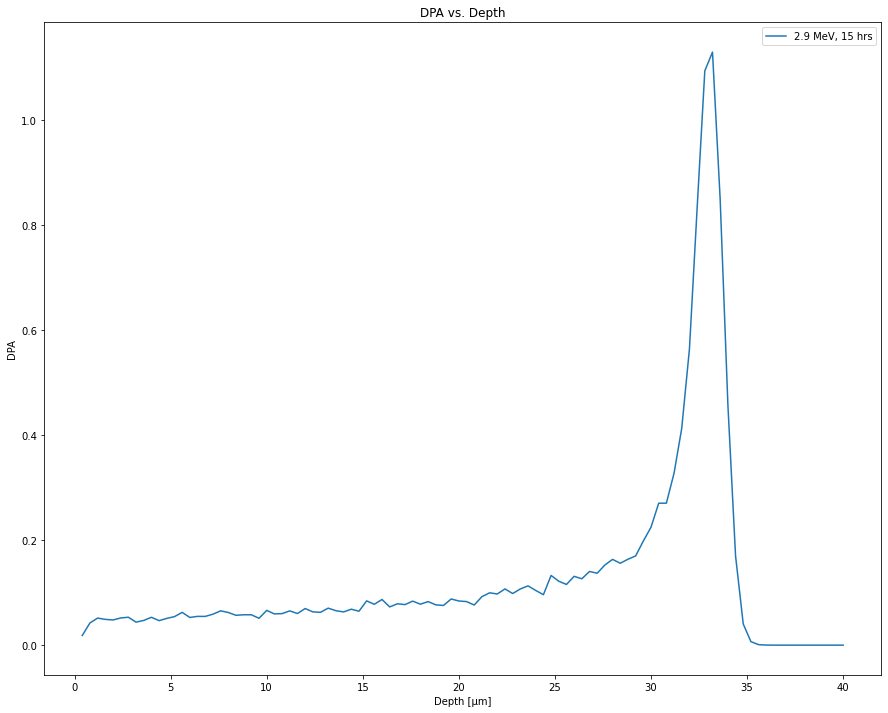

In [18]:
f = open(str(image_directory)+'/output.txt', "a")
f.write("========================= START =========================\n")
fig, ax = plt.subplots()

times = list(range(15, 30,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        dpa_calc = plot_dpa(folder, ax, time)
        ax.plot(dpa_calc[0], dpa_calc[1], label=""+str(energies[i])+", "+str(time)+" hrs")
        index = np.where(dpa_calc[1] == max(dpa_calc[1]))
        a = dpa_calc[0][index]
        info = "Max dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(dpa_calc[1]),2),  str(a)[1:-1], energies[i], time)
        print(info)
        f.write(info+"\n")
        
    ax.set_xlabel('Depth [µm]') #Angstroms
    ax.set_ylabel('DPA')
    ax.set_title('DPA vs. Depth')
    ax.legend()
    fig.set_size_inches((15, 12))
    fig.savefig(os.path.join(image_directory, 'dpa_combinedv_auto_'+str(energies[i])+'.png'), transparent=False)

f.write("============================ END ============================\n")
f.close()

NRT dpa: 0.86 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours


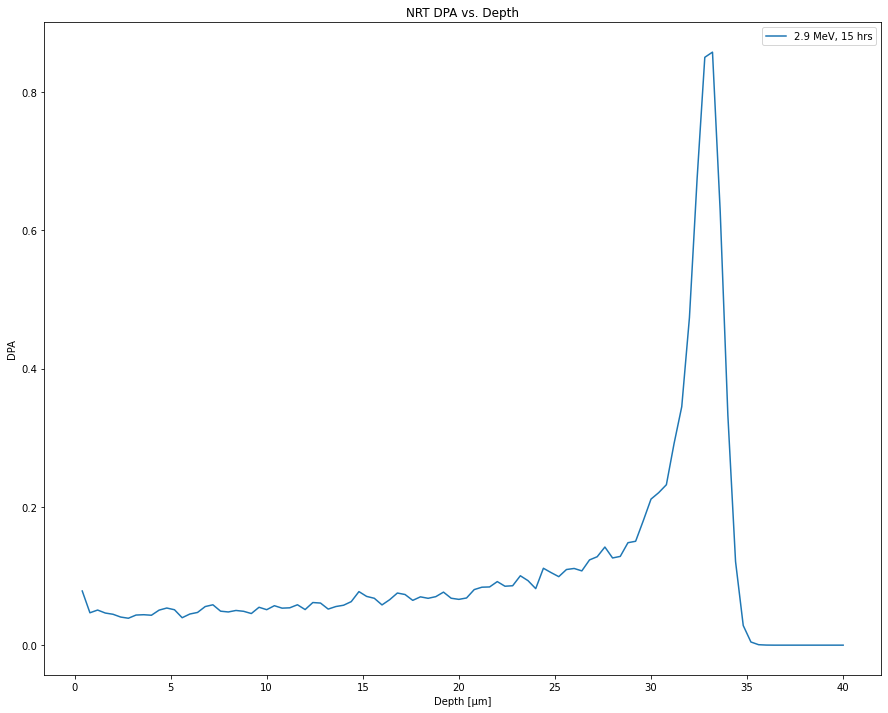

In [19]:
fig, ax = plt.subplots()

times = list(range(15, 16,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        energy_damage = NRT(folder, ax, time)
        ax.plot(energy_damage[1], energy_damage[2], label=""+str(energies[i])+", "+str(time)+" hrs")
        #print("Damage energy: {} eV".format(energy_damage[0]))
        ax.set_xlabel('Depth [µm]')
        ax.set_ylabel('DPA')
        ax.legend()
        
        index = np.where(energy_damage[2] == max(energy_damage[2]))
        a = energy_damage[1][index]
        d = str(a)[1:-1]
 
        print("NRT dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(energy_damage[2]),2), d, energies[i], time))
        
    ax.set_title('NRT DPA vs. Depth')
    fig.set_size_inches((15, 12))
    fig.savefig(os.path.join(image_directory, 'damagevsdepth.png'), transparent=False)

Max dpa: 1.13 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours
NRT dpa: 0.86 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours
NRT2 dpa: 0.89 at 33.2 µm, proton energy: 2.9 MeV, for 15 hours


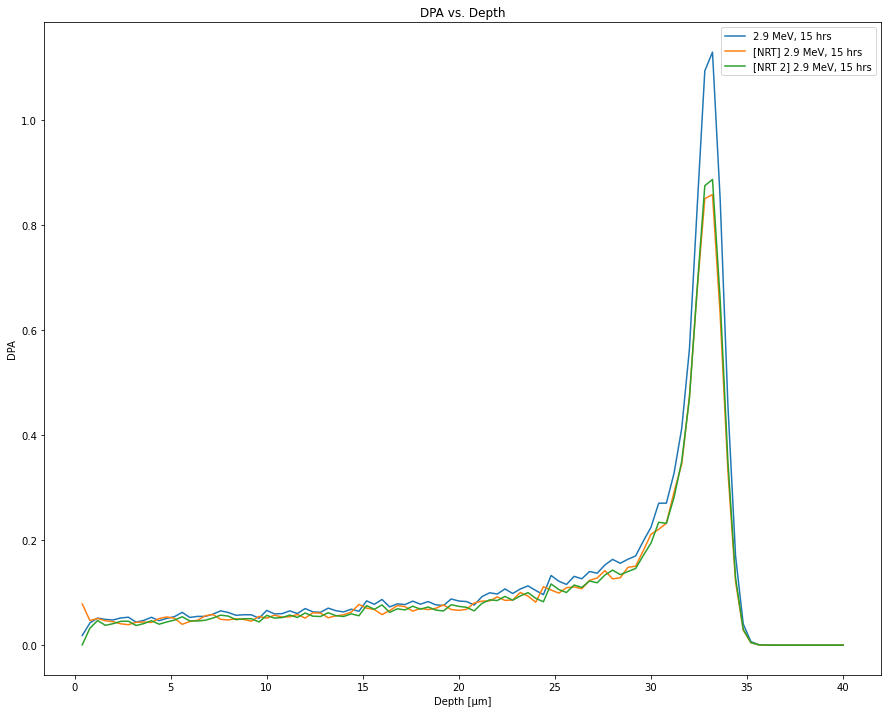

In [20]:
fig, ax = plt.subplots()

times = list(range(15, 30,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        dpa_calc = plot_dpa(folder, ax, time)
        ax.plot(dpa_calc[0], dpa_calc[1], label=""+str(energies[i])+", "+str(time)+" hrs")
        index = np.where(dpa_calc[1] == max(dpa_calc[1]))
        a = dpa_calc[0][index]
        print("Max dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(dpa_calc[1]),2),  str(a)[1:-1], energies[i], time))

        energy_damage = NRT(folder, ax, time)
        ax.plot(energy_damage[1], energy_damage[2], label="[NRT] "+str(energies[i])+", "+str(time)+" hrs")
        print("NRT dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(energy_damage[2]),2),  str(a)[1:-1], energies[i], time))
        
        energy_damage = NRT2(folder, ax, time)
        ax.plot(energy_damage[1], energy_damage[2], label="[NRT 2] "+str(energies[i])+", "+str(time)+" hrs")
        print("NRT2 dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(energy_damage[2]),2),  str(a)[1:-1], energies[i], time))
        
        
    ax.set_xlabel('Depth [µm]') #Angstroms
    ax.set_ylabel('DPA')
    ax.set_title('DPA vs. Depth')
    ax.legend()
    fig.set_size_inches((15, 12))
    fig.savefig(os.path.join(image_directory, 'dpa_combined_auto_'+str(energies[i])+'.png'), transparent=False)